# 1. Parcellation similarity

1. Parcellations are similar within a single method and a single resolution, across sparsity levels.
2. Data driven parcellations are highly similar to anatomical parcellations. Parcellations obtained using HE method are similar to parcellations obtained from Aver method. Нужна картинка с пересечением анатомического и коннективного атласа.
3. Connectivity parcellations symmetricity are on par with anatomical parcellation symetricity.

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
from sklearn.metrics import adjusted_mutual_info_score
from tqdm import tqdm
from sklearn.metrics.cluster import contingency_matrix
from glob import glob

In [100]:
pd.options.display.max_rows = 100

In [101]:
paths = []
trunc_path = []
method = []
resolution = []
sparsity = []
for dirpath, dirnames, filenames in os.walk('/data01/ayagoz/sparse_32_concon_HCP/parcellations/ensemble_parcellation'):
    if ('shuffle' not in dirpath):
        for filename in filenames:
            if '.py' not in filename:
                p = os.path.join(dirpath, filename)
                paths.append(p)
                trunc_path.append('/'.join(p.split('/')[6:]))
                if 'connectivity_parcellation_level' in p:
                    method.append('HE')
                    resolution.append(int(p.split('/')[-3][-1]))
                    sparsity.append(int(p.split('/')[-2]))
                elif 'average_network_partition' in p:
                    method.append('Aver')
                    resolution.append(int(p.split('/')[-2][-1]))
                    sparsity.append(int(p.split('/')[-1].split('_')[-1].split('.')[0]))
                elif 'CSPA' in p:
                    method.append('CSPA')
                    resolution.append(int(p.split('/')[-2][-1]))
                    sparsity.append(int(p.split('/')[-1].split('_')[-1].split('.')[0]))

In [102]:

paths.append('/data01/ayagoz/sparse_32_concon_HCP/parcellations/desikan_aparc_average_1113.npy')
paths.append('/data01/ayagoz/sparse_32_concon_HCP/parcellations/destrieux_aparc2009_average_1113.npy')
method.append('desikan_average')
method.append('destrieux_average')
resolution.append('none')
resolution.append('none')
sparsity.append('none')
sparsity.append('none')

path_meta = pd.DataFrame(paths, columns=['path_to_partition'])
path_meta['method'] = method
path_meta['resolution'] = resolution
path_meta['sparsity'] = sparsity

In [103]:
path_meta.sort_values(['method', 'resolution', 'sparsity'], inplace=True)

In [104]:
all_parc = []
for p in path_meta['path_to_partition'].values[:-2]:
    a = np.load(p)
    all_parc.append(a)
desik = np.load('/data01/ayagoz/sparse_32_concon_HCP/parcellations/desikan_aparc_average_1113.npy')
destr = np.load('/data01/ayagoz/sparse_32_concon_HCP/parcellations/destrieux_aparc2009_average_1113.npy')
idx = desik!=-1
all_parc.append(desik[idx])
all_parc.append(destr[idx])
all_parc = np.array(all_parc)
all_parc.shape

(92, 18869)

In [105]:
def compute_ami_parallel(partitions, n_jobs=10):
    from joblib import Parallel, delayed
    n = len(partitions)
    row, col = np.triu_indices(n)
    amis = Parallel(n_jobs=n_jobs)(delayed(adjusted_mutual_info_score)(partitions[i],
                                                           partitions[j]) for i,j in zip(row, col))
    result = np.zeros((n, n))
    result[row, col] = amis
    result[col, row] = amis
    return result

In [106]:
result = compute_ami_parallel(all_parc)
# result = np.eye(92)
# for i in tqdm(range(92)):
#     for j in range(i, 92):
#         a = adjusted_mutual_info_score(all_parc[i], all_parc[j])
#         result[i, j] = a
#         result[j, i] = a

KeyboardInterrupt: 

In [ ]:
cols = []
for m, r, s in zip(path_meta['method'].values,
                   path_meta['resolution'].values,
                   path_meta['sparsity'].values):
    cols.append(f'{m}_{r}_{s}')

In [ ]:
ami_ensemble = pd.DataFrame(result, columns=cols)
ami_ensemble.index=cols

In [ ]:
plt.imshow(ami_ensemble)
plt.colorbar()

In [ ]:
ind = [np.arange(i, i+10) for i in range(0, 90, 10)]
mat = np.zeros((9,9))
for i, i1 in enumerate(ind):
    for j, i2 in enumerate(ind):
        x = np.round(ami_ensemble.iloc[i1, i2].values.mean(), 3)
        mat[i, j] = x
        mat[j, i] = x
cols = ['Aver1', 'Aver2', 'Aver3', 'CSPA1', 'CSPA2', 'CSPA3', 'HE1', 'HE2', 'HE3']
aver_sim_ensemble = pd.DataFrame(mat, columns=cols)
aver_sim_ensemble.index = cols

In [ ]:
aver_sim_ensemble

In [14]:
mat = np.zeros((11,11))
for i, i1 in enumerate(ind):
    for j, i2 in enumerate(ind):
#         print(i1, i2)
        x = np.round(ami_ensemble.iloc[i1, i2].values.mean(), 2)
#         print(i, j)
        mat[i, j] = x
        mat[j, i] = x
for a, i in enumerate(ind):
    mat[9, a] = np.round(ami_ensemble.iloc[90, i].values.mean(), 2)
    mat[10, a] = np.round(ami_ensemble.iloc[91, i].values.mean(), 2)
    mat[a, 9] = mat[9, a]
    mat[a, 10] = mat[10, a]
mat[9,9] = np.round(ami_ensemble.iloc[90,90], 2)
mat[10,10] = np.round(ami_ensemble.iloc[91,91], 2)
mat[9, 10] = np.round(ami_ensemble.iloc[90, 91], 2)
mat[10, 9] = np.round(ami_ensemble.iloc[91, 90], 2)

mat2 = mat[[6,7,8,0,1,2,3,4,5,9,10], :][:, [6,7,8,0,1,2,3,4,5,9,10]]
cols = ['Aver1', 'Aver2', 'Aver3', 'CSPA1', 'CSPA2', 'CSPA3', 'HE1', 'HE2', 'HE3', 'Desikan', 'Destrieux']
aver_sim_ensemble = pd.DataFrame(mat, columns=cols)
aver_sim_ensemble.index = cols
aver_sim_ensemble

,Aver1,Aver2,Aver3,CSPA1,CSPA2,CSPA3,HE1,HE2,HE3,Desikan,Destrieux
Aver1,0.94,0.51,0.39,0.68,0.70,0.55,0.77,0.45,0.35,0.33,0.30
Aver2,0.51,0.95,0.74,0.41,0.48,0.53,0.47,0.80,0.65,0.58,0.53
Aver3,0.39,0.74,0.95,0.32,0.39,0.43,0.37,0.66,0.81,0.64,0.64
CSPA1,0.68,0.41,0.32,0.90,0.60,0.47,0.78,0.40,0.31,0.28,0.26
CSPA2,0.70,0.48,0.39,0.60,0.96,0.66,0.70,0.49,0.38,0.35,0.31
CSPA3,0.55,0.53,0.43,0.47,0.66,0.83,0.55,0.55,0.45,0.40,0.36
HE1,0.77,0.47,0.37,0.78,0.70,0.55,0.94,0.46,0.36,0.34,0.31
HE2,0.45,0.80,0.66,0.40,0.49,0.55,0.46,0.91,0.66,0.58,0.53
HE3,0.35,0.65,0.81,0.31,0.38,0.45,0.36,0.66,0.91,0.65,0.65
Desikan,0.33,0.58,0.64,0.28,0.35,0.40,0.34,0.58,0.65,1.00,0.66


In [15]:
cols = ['$HE_1$', '$HE_2$', '$HE_3$','$Aver_1$', '$Aver_2$', '$Aver_3$', '$CSPA_1$', '$CSPA_2$', '$CSPA_3$', '$Desikan$', '$Destrieux$']
aver_sim_ensemble = pd.DataFrame(np.round(mat2*100).astype(int), columns=cols)
# aver_sim_ensemble = pd.DataFrame(mat2, columns=cols)
aver_sim_ensemble.index = cols
aver_sim_ensemble

,$HE_1$,$HE_2$,$HE_3$,$Aver_1$,$Aver_2$,$Aver_3$,$CSPA_1$,$CSPA_2$,$CSPA_3$,$Desikan$,$Destrieux$
$HE_1$,94,46,36,77,47,37,78,70,55,34,31
$HE_2$,46,91,66,45,80,66,40,49,55,58,53
$HE_3$,36,66,91,35,65,81,31,38,45,65,65
$Aver_1$,77,45,35,94,51,39,68,70,55,33,30
$Aver_2$,47,80,65,51,95,74,41,48,53,58,53
$Aver_3$,37,66,81,39,74,95,32,39,43,64,64
$CSPA_1$,78,40,31,68,41,32,90,60,47,28,26
$CSPA_2$,70,49,38,70,48,39,60,96,66,35,31
$CSPA_3$,55,55,45,55,53,43,47,66,83,40,36
$Desikan$,34,58,65,33,58,64,28,35,40,100,66


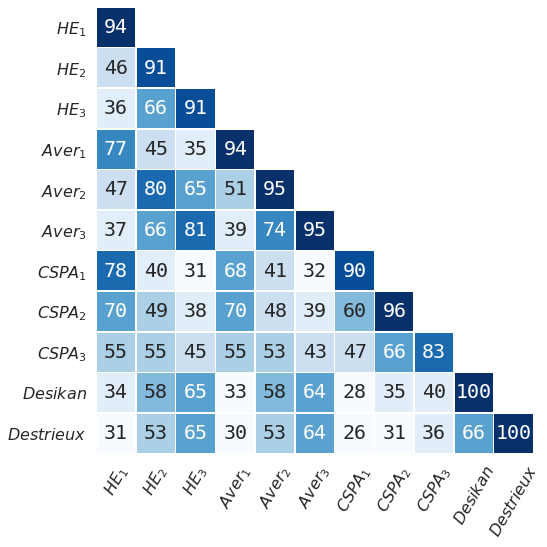

In [25]:
import matplotlib.pyplot as plt
from matplotlib import cm as colormaps
import seaborn as sns
sns.set()
font = {'family' : 'monospace',
        'size'   : 20}

plt.rc('font', **font)
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(8,8))

# fmt = lambda x,pos: '{:.0%}'.format(x)
# sns.heatmap(uniform_data, annot=true, fmt='.0%',
#             cbar_kws={'format': funcformatter(fmt)})

mask = np.zeros_like(aver_sim_ensemble, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True
cmap = colormaps.get_cmap('Blues', 10) # jet doesn't have white color
cmap.set_bad('w') 

sns.heatmap(aver_sim_ensemble,
            annot=True,
            linewidths=.5,
            fmt='',
            ax=ax,
            mask=mask,
            cmap=cmap,
            cbar=False)
ax.tick_params(axis='x', rotation=60, labelsize=16)
ax.tick_params(axis='y', rotation=0, labelsize=16)
f.tight_layout()
f.savefig('/home/kurmukov/parcellation_similarity.png', dpi=300, transparent=True)
# plt.colorbar()

# Similarity to Desikan

Сложна, надо думать

In [107]:
he3_10 = np.load('/data01/ayagoz/sparse_32_concon_HCP/parcellations/ensemble_parcellation/connectivity_parcellation_level3/10/ensemble_3_10.npy')
desik = np.load('/data01/ayagoz/sparse_32_concon_HCP/parcellations/desikan_aparc_average_1113.npy')
destr = np.load('/data01/ayagoz/sparse_32_concon_HCP/parcellations/destrieux_aparc2009_average_1113.npy')
destr = destr[desik!=-1]
desik = desik[desik!=-1]


In [108]:
adjusted_mutual_info_score(he3_10, destr)

/home/kurmukov/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.6574966539717602

In [109]:
m = contingency_matrix(he3_10, destr).T

In [110]:
desikan_ind = []
he3_ind = []
desikan_perc = []
he3_perc = []
size_inters = []
size_desik = []
size_he3 = []
#   
for i,row in enumerate(m):
#     jj = len(np.nonzero(row[np.argsort(row)[::-1]])[0])
#     j = np.argsort(row)[::-1][:jj]
#     for ind in j:
#         desikan_ind.append(i)
#         he3_ind.append(ind)
#         desikan_perc.append(row[ind]/row.sum())
#         he3_perc.append(m[i, ind]/m[:,ind].sum())
#         size.append(row[ind])
    ind = np.argsort(row)[::-1][0]
    desikan_ind.append(i)
    he3_ind.append(ind)
    desikan_perc.append(row[ind]/row.sum())
    he3_perc.append(m[i, ind]/m[:,ind].sum())
    size_inters.append(row[ind])
    size_desik.append(row.sum())
    size_he3.append( m[:, ind].sum())

In [111]:
df = pd.DataFrame()
df['destr_ind'] = desikan_ind
df['he3_ind'] = he3_ind
df['destr_perc'] = np.round(desikan_perc, 3)
df['he3_perc'] =np.round( he3_perc,3)
df['size'] = size_inters
df['size_destr'] = size_desik
df['size_he3'] = size_he3
df['sum'] = df['destr_perc'] + df['he3_perc']
df['dice'] = 2*df['size']/(df['size_destr'] + df['size_he3'])

In [112]:
df.sort_values('dice', ascending=False)

,destr_ind,he3_ind,destr_perc,he3_perc,size,size_destr,size_he3,sum,dice
3,3,29,0.975,0.776,156,160,201,1.751,0.864266
86,86,67,0.892,0.569,91,102,160,1.461,0.694656
12,12,63,0.717,0.628,81,113,129,1.345,0.669421
77,77,23,0.838,0.531,129,154,243,1.369,0.649874
69,69,35,0.910,0.472,101,111,214,1.382,0.621538
49,49,18,0.635,0.605,127,200,210,1.240,0.619512
61,61,82,0.743,0.514,110,148,214,1.257,0.607735
6,6,13,0.682,0.505,107,157,212,1.187,0.579946
130,130,57,0.605,0.540,161,266,298,1.145,0.570922
26,26,22,0.495,0.639,138,279,216,1.134,0.557576


In [113]:
vals1 = df.sort_values('dice', ascending=False).dice

In [117]:
m = contingency_matrix(desik, destr)

desikan_ind = []
he3_ind = []
desikan_perc = []
he3_perc = []
size_inters = []
size_desik = []
size_he3 = []
#   
for i,row in enumerate(m):
#     jj = len(np.nonzero(row[np.argsort(row)[::-1]])[0])
#     j = np.argsort(row)[::-1][:jj]
#     for ind in j:
#         desikan_ind.append(i)
#         he3_ind.append(ind)
#         desikan_perc.append(row[ind]/row.sum())
#         he3_perc.append(m[i, ind]/m[:,ind].sum())
#         size.append(row[ind])
    ind = np.argsort(row)[::-1][0]
    desikan_ind.append(i)
    he3_ind.append(ind)
    desikan_perc.append(row[ind]/row.sum())
    he3_perc.append(m[i, ind]/m[:,ind].sum())
    size_inters.append(row[ind])
    size_desik.append(row.sum())
    size_he3.append( m[:, ind].sum())
    
df = pd.DataFrame()
df['desikan_ind'] = desikan_ind
df['destrieux_ind'] = he3_ind
df['desikan_perc'] = np.round(desikan_perc, 3)
df['destrieux_perc'] =np.round( he3_perc,3)
df['size'] = size_inters
df['size_desik'] = size_desik
df['size_destrieux'] = size_he3
df['sum'] = df['desikan_perc'] + df['destrieux_perc']
df['dice'] = 2*df['size']/(df['size_desik'] + df['size_destrieux'])

df.sort_values('dice', ascending=False)
vals2 = df.sort_values('dice', ascending=False).dice

In [118]:
df.sort_values('dice', ascending=False)

,desikan_ind,he3_ind,desikan_perc,he3_perc,size,size_desik,size_he3,sum,dice
3,3,11,0.687,0.823,79,115,96,1.510,0.748815
37,37,85,0.684,0.812,78,114,96,1.496,0.742857
13,13,38,0.579,0.965,165,285,171,1.544,0.723684
11,11,22,0.580,0.958,160,276,167,1.538,0.722348
26,26,16,0.602,0.898,466,774,519,1.500,0.720804
7,7,37,0.549,1.000,147,268,147,1.549,0.708434
66,66,107,0.625,0.811,30,48,37,1.436,0.705882
41,41,111,0.528,1.000,141,267,141,1.528,0.691176
47,47,112,0.533,0.976,163,306,167,1.509,0.689218
32,32,33,0.590,0.818,36,61,44,1.408,0.685714


In [79]:
individual = dict()
for a in range(10, 101, 10):
    i = glob(f'/data01/ayagoz/sparse_32_concon_HCP/parcellations/connectivity_parcellation_level3/{a}/*.npy')[:100]
    i = [s for s in i if '142626.npy' not in s]
    i = sorted(i, key=lambda x: x.split('/')[-1])
    individual[a] = i
# level3_individual_clustering = Parallel(18)(delayed(compute_clustering)(np.load(path), mode) for path in tqdm(individual))
# CC['individual_louvain_level3'] = level3_individual_clustering

In [80]:
t = []
parc = []
u = []
for key, val in individual.items():
    for p in val:
        parc.append(np.load(p))
        t.append(key)
        u.append(p.split('/')[-1].split('.')[0])

In [81]:
ind = np.argsort(u)

In [82]:
parc = np.array(parc)

In [83]:
parc = parc[ind]

In [84]:
parc.shape

(990, 18869)

In [74]:
parc[0].shape

(18869,)

In [ ]:
res = compute_ami_parallel(parc)

In [85]:
u = np.array(u)

In [86]:
u[ind]

array(['100307', '100307', '100307', '100307', '100307', '100307',
       '100307', '100307', '100307', '100307', '101915', '101915',
       '101915', '101915', '101915', '101915', '101915', '101915',
       '101915', '101915', '103818', '103818', '103818', '103818',
       '103818', '103818', '103818', '103818', '103818', '103818',
       '104416', '104416', '104416', '104416', '104416', '104416',
       '104416', '104416', '104416', '104416', '105014', '105216',
       '105216', '105216', '105216', '105216', '105216', '105216',
       '105216', '105216', '105216', '106319', '106319', '106319',
       '106319', '106319', '106319', '106319', '106319', '106319',
       '106319', '107018', '107018', '107018', '107018', '107018',
       '108222', '110411', '110411', '110411', '110411', '110411',
       '110411', '110411', '110411', '110411', '110411', '110613',
       '110613', '110613', '110613', '110613', '110613', '110613',
       '110613', '110613', '110613', '111413', '111413', '1114

In [88]:
amis = []
for i in tqdm(range(0, 980, 10)):
    am = compute_ami_parallel(parc[i:i+10], 20)
    amis.append(np.mean(am))


100%|██████████| 98/98 [01:19<00:00,  1.28it/s]

In [89]:
np.mean(amis), np.std(amis)

(0.829507229092439, 0.04838049666850417)

In [90]:
def create_average_parcellation(labels):
    '''
    Creates average parcellation from set of labels,
    for every vertex chooses most frequent label.
    
    Parameters
    -----
    
    labels - ndarray,
     N x M array, N subject, M number of mesh vertices to label
     
    Returns
    -----
    average_label - ndarray,
     array of labels of length M
    '''
    n, m = labels.shape
    average_labels = np.zeros(m)
    for i in range(m):
        vals, freq = np.unique(labels[:, i], return_counts=True)
        ind = np.argmax(freq)
        average_labels[i] = vals[ind]
    return average_labels

In [92]:
aver = []
for i in tqdm(range(100)):
    ind = np.arange(1000)
    np.random.shuffle(ind)
    ind = ind[:50]
    parc = []
    for p in np.array(glob('/data01/ayagoz/sparse_32_concon_HCP/parcellations/desikan_aparc/*.npy'))[ind]:
        parc.append(np.load(p))
    aver.append(create_average_parcellation(np.array(parc)))


100%|██████████| 100/100 [00:48<00:00,  2.10it/s]

In [94]:
result_desik = compute_ami_parallel(aver, 20)

In [95]:
aver_destrieux = []
for i in tqdm(range(100)):
    ind = np.arange(1000)
    np.random.shuffle(ind)
    ind = ind[:50]
    parc = []
    for p in np.array(glob('/data01/ayagoz/sparse_32_concon_HCP/parcellations/destrieux_aparc2009/*.npy'))[ind]:
        parc.append(np.load(p))
    aver_destrieux.append(create_average_parcellation(np.array(parc)))


100%|██████████| 100/100 [00:44<00:00,  2.59it/s]

In [96]:
result_destrieux = compute_ami_parallel(aver_destrieux, 20)

In [97]:
np.mean(result_desik), np.std(result_desik)

(0.9896157724943517, 0.0012914205908729054)

In [98]:
np.mean(result_destrieux), np.std(result_destrieux)

(0.9758991336374836, 0.0026335009599060284)

# Dice for Boris

In [387]:
he3_10 = np.load('/data01/ayagoz/sparse_32_concon_HCP/parcellations/ensemble_parcellation/connectivity_parcellation_level3/10/ensemble_3_10.npy')
desik = np.load('/data01/ayagoz/sparse_32_concon_HCP/parcellations/desikan_aparc_average_1113.npy')
destr = np.load('/data01/ayagoz/sparse_32_concon_HCP/parcellations/destrieux_aparc2009_average_1113.npy')
destr = destr[desik!=-1]
desik = desik[desik!=-1]


In [388]:
m = contingency_matrix(he3_10, desik).T

In [389]:
desikan_ind = []
he3_ind = []
desikan_perc = []
he3_perc = []
size_inters = []
size_desik = []
size_he3 = []
#   
for i,row in enumerate(m):
    jj = len(np.nonzero(row[np.argsort(row)[::-1]])[0])
    j = np.argsort(row)[::-1][:jj]
    for ind in j:
        desikan_ind.append(i)
        he3_ind.append(ind)
        desikan_perc.append(row[ind]/row.sum())
        he3_perc.append(m[i, ind]/m[:,ind].sum())
        size_inters.append(row[ind])
        size_desik.append(row.sum())
        size_he3.append( m[:, ind].sum())
#     ind = np.argsort(row)[::-1][0]
#     desikan_ind.append(i)
#     he3_ind.append(ind)
#     desikan_perc.append(row[ind]/row.sum())
#     he3_perc.append(m[i, ind]/m[:,ind].sum())
#     size_inters.append(row[ind])
#     size_desik.append(row.sum())
#     size_he3.append( m[:, ind].sum())
    
df = pd.DataFrame()
df['Desikan_INDEX'] = desikan_ind
df['he3_INDEX'] = he3_ind
df['destr_perc'] = np.round(desikan_perc, 3)
df['he3_perc'] =np.round( he3_perc,3)
df['size_intersection'] = size_inters
df['size_Desikan_region'] = size_desik
df['size_he3_region'] = size_he3
# df['sum'] = df['destr_perc'] + df['he3_perc']
df['dice'] = 2*df['size_intersection']/(df['size_Desikan_region'] + df['size_he3_region'])
# df

In [390]:
df = df.query('destr_perc > .0 and he3_perc > .0').drop(['destr_perc', 'he3_perc'], axis=1)

In [391]:
a = df[['Desikan_INDEX', 'size_Desikan_region']]
desik_size = dict(zip(a['Desikan_INDEX'], a['size_Desikan_region']))
df = df.groupby('Desikan_INDEX')['size_intersection', 'size_he3_region'].sum()
df['size_Desikan_region'] = desik_size.values()
df = df.reset_index()
df['Desikan_INDEX'] = np.unique(desik).astype(int)
df['dice'] = 2*df['size_intersection']/(df['size_Desikan_region'] + df['size_he3_region'])
df['error'] = np.round(100*(df['size_Desikan_region'] - df['size_intersection']) / df['size_Desikan_region'])

In [392]:
region_names = """
bankssts                
caudalanteriorcingulate 
caudalmiddlefrontal     
cuneus                  
entorhinal              
fusiform                
inferiorparietal        
inferiortemporal        
isthmuscingulate        
lateraloccipital        
lateralorbitofrontal    
lingual                 
medialorbitofrontal     
middletemporal          
parahippocampal         
paracentral             
parsopercularis         
parsorbitalis           
parstriangularis        
pericalcarine           
postcentral             
posteriorcingulate      
precentral              
precuneus               
rostralanteriorcingulate
rostralmiddlefrontal    
superiorfrontal         
superiorparietal        
superiortemporal        
supramarginal           
frontalpole             
temporalpole            
transversetemporal      
insula                  
"""


In [393]:
d = dict(zip([
    1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
],[region+'_LH' for region in region_names.split()]))

d2 = dict(zip(np.array([1,2,3,5,6,7,8,9,10,
                        11,12,13,14,15,16,17,
                        18,19,20,21,22,23,24,
                        25,26,27,28,29,30,31,
                        32,33,34,35])+35, [region+'_RH' for region in region_names.split()]))
d.update(d2)
df['Desikan_REGION_NAME'] = df['Desikan_INDEX'].apply(lambda x:d[x])

In [394]:
df.sort_values('dice', ascending=False).to_csv('/home/kurmukov/Desikan_HE3_dice_0.csv')
df.head()

,Desikan_INDEX,size_intersection,size_he3_region,size_Desikan_region,dice,error,Desikan_REGION_NAME
0,1,131,634,131,0.342484,0.0,bankssts_LH
1,2,77,490,77,0.271605,0.0,caudalanteriorcingulate_LH
2,3,254,1051,254,0.389272,0.0,caudalmiddlefrontal_LH
3,5,115,556,115,0.342772,0.0,cuneus_LH
4,6,49,529,49,0.169550,0.0,entorhinal_LH


In [283]:
from nilearn.surface import load_surf_data

In [285]:
l = load_surf_data("/data01/ayagoz/HCP_1200/FS_reconall/521331/label/lh.aparc.annot")